# NYC_Parking_Violations_IBM_Capstone
## Notebook 3
## Models to predict top four Violations

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200418225703-0000
KERNEL_ID = 455fd538-0082-444f-8f5e-91ddefe01eca


,Unnamed: 0,Fine Amount,Penalty Amount,Reduction Amount,Payment Amount,Amount Due,Precinct,Year,Month,Day,State_index,License_Type_index,Violation_index,County_index,Issuing_Agency_index
0,0,35.0,10.0,0.0,0.0,45.00,110,2018,2,16,0.0,1.0,2.0,2.0,0.0
1,1,35.0,60.0,0.0,0.0,109.94,114,2017,12,20,0.0,0.0,2.0,2.0,0.0
2,2,35.0,60.0,0.0,0.0,110.91,115,2017,10,6,1.0,0.0,2.0,2.0,0.0
3,3,35.0,10.0,0.0,0.0,45.00,46,2018,3,24,10.0,0.0,2.0,3.0,0.0
4,4,35.0,10.0,0.0,0.0,45.00,46,2018,6,25,3.0,0.0,2.0,3.0,0.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

In [3]:
%matplotlib inline

### Split training and test data

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X = df_data_5[['Fine Amount', 'Penalty Amount', 'Reduction Amount', 'Payment Amount',
       'Amount Due', 'Precinct', 'Year', 'Month', 'Day', 'State_index',
       'License_Type_index', 'County_index',
       'Issuing_Agency_index']].values

In [6]:
y = df_data_5[['Violation_index']].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
X_train.shape

(67869, 13)

In [9]:
X_test.shape

(29088, 13)

## Deep Learning model without data normalization

In [10]:
model = Sequential()

model.add(Dense(13,activation='relu'))

model.add(Dense(16,activation='relu'))

model.add(Dense(16,activation='relu'))

model.add(Dense(4,activation='softmax'))


model.compile(loss ='sparse_categorical_crossentropy', optimizer = 'adam',metrics=['sparse_categorical_accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.fit(x=X_train,y=y_train,epochs = 20,validation_data=(X_test,y_test))

Train on 67869 samples, validate on 29088 samples
Epoch 1/20
67869/67869 [==============================] - 8s 114us/sample - loss: 11.5355 - sparse_categorical_accuracy: 0.2843 - val_loss: 11.5489 - val_sparse_categorical_accuracy: 0.2835
Epoch 2/20
67869/67869 [==============================] - 7s 103us/sample - loss: 11.5355 - sparse_categorical_accuracy: 0.2843 - val_loss: 11.5489 - val_sparse_categorical_accuracy: 0.2835
Epoch 3/20
67869/67869 [==============================] - 7s 103us/sample - loss: 11.5355 - sparse_categorical_accuracy: 0.2843 - val_loss: 11.5489 - val_sparse_categorical_accuracy: 0.2835
Epoch 4/20
67869/67869 [==============================] - 7s 102us/sample - loss: 11.5355 - sparse_categorical_accuracy: 0.2843 - val_loss: 11.5489 - val_sparse_categorical_accuracy: 0.2835
Epoch 5/20
67869/67869 [==============================] - 7s 103us/sample - loss: 11.5355 - sparse_categorical_accuracy: 0.2843 - val_loss: 11.5489 - val_sparse_categorical_accuracy: 0.2835


### Model Evaluation

accuracy =  0.2843124270439148
val_accuracy =  0.2834846079349518


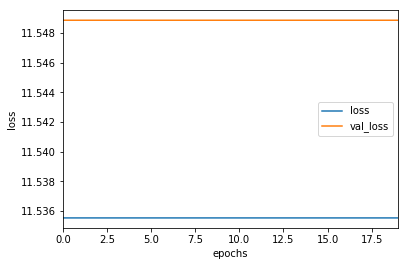

In [12]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()
plt.xlabel('epochs')
plt.ylabel('loss')
print("accuracy = ",losses[['sparse_categorical_accuracy']].iloc[-1][0])
print("val_accuracy = ",losses[['val_sparse_categorical_accuracy']].iloc[-1][0])

In [13]:
predictions = model.predict_classes(X_test)

In [14]:
violation = {'NO PARKING-STREET CLEANING':0,
             'PHTO SCHOOL ZN SPEED VIOLATION':1,
             'FAIL TO DSPLY MUNI METER RECPT':2,
             'NO STANDING-DAY/TIME LIMITS':3}
#for key in violation:
#    print(key, ':', violation[key])

In [15]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      9282
         1.0       0.28      1.00      0.44      8246
         2.0       0.00      0.00      0.00      6328
         3.0       0.00      0.00      0.00      5232

   micro avg       0.28      0.28      0.28     29088
   macro avg       0.07      0.25      0.11     29088
weighted avg       0.08      0.28      0.13     29088



/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
confusion_matrix(y_test,predictions)

array([[   0, 9282,    0,    0],
       [   0, 8246,    0,    0],
       [   0, 6328,    0,    0],
       [   0, 5232,    0,    0]])

## Deep Learning model with data normalization

In [17]:
scaler = MinMaxScaler()

In [18]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
X_train = scaler.transform(X_train)

In [20]:
X_test = scaler.transform(X_test)

In [21]:
model = Sequential()

model.add(Dense(13,activation='relu'))

model.add(Dense(16,activation='relu'))

model.add(Dense(16,activation='relu'))

model.add(Dense(4,activation='softmax'))

model.compile(loss ='sparse_categorical_crossentropy', optimizer = 'adam',metrics=['sparse_categorical_accuracy'])

In [22]:
model.fit(x=X_train,y=y_train,epochs = 20,validation_data=(X_test,y_test))

Train on 67869 samples, validate on 29088 samples
Epoch 1/20
67869/67869 [==============================] - 8s 117us/sample - loss: 0.4388 - sparse_categorical_accuracy: 0.8202 - val_loss: 0.1642 - val_sparse_categorical_accuracy: 0.9593
Epoch 2/20
67869/67869 [==============================] - 7s 105us/sample - loss: 0.0953 - sparse_categorical_accuracy: 0.9682 - val_loss: 0.0657 - val_sparse_categorical_accuracy: 0.9693
Epoch 3/20
67869/67869 [==============================] - 7s 108us/sample - loss: 0.0625 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.0562 - val_sparse_categorical_accuracy: 0.9704
Epoch 4/20
67869/67869 [==============================] - 7s 104us/sample - loss: 0.0586 - sparse_categorical_accuracy: 0.9702 - val_loss: 0.0561 - val_sparse_categorical_accuracy: 0.9691
Epoch 5/20
67869/67869 [==============================] - 7s 106us/sample - loss: 0.0562 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.0511 - val_sparse_categorical_accuracy: 0.9718
Epoch 6/20

### Model Evaluation

accuracy =  0.9717691540718079
val_accuracy =  0.9716033935546875


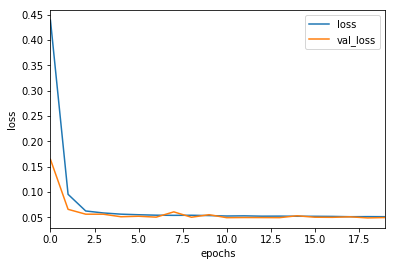

In [23]:
losses_2 = pd.DataFrame(model.history.history)
losses_2[['loss','val_loss']].plot()
plt.xlabel('epochs')
plt.ylabel('loss')
print("accuracy = ",losses_2[['sparse_categorical_accuracy']].iloc[-1][0])
print("val_accuracy = ",losses_2[['val_sparse_categorical_accuracy']].iloc[-1][0])

In [24]:
predictions = model.predict_classes(X_test)

In [25]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96      9282
         1.0       1.00      1.00      1.00      8246
         2.0       0.94      0.92      0.93      6328
         3.0       1.00      1.00      1.00      5232

   micro avg       0.97      0.97      0.97     29088
   macro avg       0.97      0.97      0.97     29088
weighted avg       0.97      0.97      0.97     29088



In [26]:
confusion_matrix(y_test,predictions)

array([[8941,    0,  341,    0],
       [   0, 8246,    0,    0],
       [ 482,    0, 5843,    3],
       [   0,    0,    0, 5232]])

## Decisioin Tree Models

In [27]:
assembler = VectorAssembler(inputCols=['Fine Amount',
                                       'Penalty Amount',
                                       'Reduction Amount',
                                       'Payment Amount',
                                       'Amount Due',
                                       'Precinct', 'Year',
                                       'Month',
                                       'Day',
                                       'State_index',
                                       'License_Type_index',
                                       'County_index',
                                       'Issuing_Agency_index'],outputCol='features')

In [28]:
df = spark.createDataFrame(df_data_5)

In [29]:
df_assembler_out = assembler.transform(df)

In [30]:
df_assembler_out.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- Fine Amount: double (nullable = true)
 |-- Penalty Amount: double (nullable = true)
 |-- Reduction Amount: double (nullable = true)
 |-- Payment Amount: double (nullable = true)
 |-- Amount Due: double (nullable = true)
 |-- Precinct: long (nullable = true)
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- Day: long (nullable = true)
 |-- State_index: double (nullable = true)
 |-- License_Type_index: double (nullable = true)
 |-- Violation_index: double (nullable = true)
 |-- County_index: double (nullable = true)
 |-- Issuing_Agency_index: double (nullable = true)
 |-- features: vector (nullable = true)



In [31]:
df_final = df_assembler_out.select('features','Violation_index')

In [32]:
df_final.show(5)

+--------------------+---------------+
|            features|Violation_index|
+--------------------+---------------+
|[35.0,10.0,0.0,0....|            2.0|
|[35.0,60.0,0.0,0....|            2.0|
|[35.0,60.0,0.0,0....|            2.0|
|[35.0,10.0,0.0,0....|            2.0|
|[35.0,10.0,0.0,0....|            2.0|
+--------------------+---------------+
only showing top 5 rows



In [33]:
train_data,test_data = df_final.randomSplit([0.7,0.3])

In [34]:
from pyspark.ml.classification import (DecisionTreeClassifier, RandomForestClassifier)

In [35]:
dtc = DecisionTreeClassifier(labelCol='Violation_index', featuresCol='features')
rfc = RandomForestClassifier(labelCol='Violation_index', featuresCol='features')

In [36]:
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)

In [37]:
dtc_preds = dtc_model.transform(test_data)
rfc_preds = rfc_model.transform(test_data)

In [38]:
df_dtc = dtc_preds.toPandas()
df_rfc = rfc_preds.toPandas()

In [39]:
df_dtc.head()

,features,Violation_index,rawPrediction,probability,prediction
0,"(35.0, 10.0, 45.0, 0.0, 0.0, 61.0, 2016.0, 5.0...",2.0,"[0.0, 0.0, 11544.0, 0.0]","[0.0, 0.0, 1.0, 0.0]",2.0
1,"(35.0, 10.0, 45.0, 0.0, 0.0, 61.0, 2016.0, 5.0...",2.0,"[0.0, 0.0, 11544.0, 0.0]","[0.0, 0.0, 1.0, 0.0]",2.0
2,"(35.0, 10.0, 45.0, 0.0, 0.0, 61.0, 2017.0, 3.0...",2.0,"[0.0, 0.0, 11544.0, 0.0]","[0.0, 0.0, 1.0, 0.0]",2.0
3,"(35.0, 10.0, 45.0, 0.0, 0.0, 61.0, 2017.0, 8.0...",2.0,"[0.0, 0.0, 11544.0, 0.0]","[0.0, 0.0, 1.0, 0.0]",2.0
4,"(35.0, 10.0, 45.0, 0.0, 0.0, 66.0, 2017.0, 7.0...",2.0,"[0.0, 0.0, 11544.0, 0.0]","[0.0, 0.0, 1.0, 0.0]",2.0


## Decision Tree Classifier Evaluation

In [40]:
print(classification_report(df_dtc['Violation_index'].values, df_dtc['prediction'].values))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      9107
         1.0       1.00      1.00      1.00      8124
         2.0       0.98      0.86      0.92      6422
         3.0       1.00      1.00      1.00      5376

   micro avg       0.97      0.97      0.97     29029
   macro avg       0.97      0.96      0.97     29029
weighted avg       0.97      0.97      0.97     29029



In [41]:
confusion_matrix(df_dtc['Violation_index'].values, df_dtc['prediction'].values)

array([[9009,    0,   96,    2],
       [   0, 8124,    0,    0],
       [ 885,    0, 5535,    2],
       [   0,    0,    0, 5376]])

## Random Forest Classifier Evaluation

In [42]:
print(classification_report(df_rfc['Violation_index'].values, df_rfc['prediction'].values))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      9107
         1.0       1.00      1.00      1.00      8124
         2.0       0.98      0.86      0.92      6422
         3.0       1.00      1.00      1.00      5376

   micro avg       0.96      0.96      0.96     29029
   macro avg       0.97      0.96      0.97     29029
weighted avg       0.97      0.96      0.96     29029



In [43]:
confusion_matrix(df_rfc['Violation_index'].values, df_rfc['prediction'].values)

array([[8995,    0,  109,    3],
       [   0, 8124,    0,    0],
       [ 900,    0, 5517,    5],
       [   2,    0,    0, 5374]])